In [3]:
from helper_functions import walk_through_dir

In [54]:
# !pip install scikit-learn

In [55]:
# !pip install kagglehub

Run the below cell only at first time

In [56]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("saurabhbagchi/deepfake-image-detection")

# print("Path to dataset files:", path)

In [4]:
walk_through_dir('./data')

There are 3 directories and 0 images in './data'.
There are 1 directories and 0 images in './data\Sample_fake_images'.
There are 1 directories and 0 images in './data\Sample_fake_images\Sample_fake_images'.
There are 0 directories and 5 images in './data\Sample_fake_images\Sample_fake_images\fake'.
There are 1 directories and 0 images in './data\test-20250112T065939Z-001'.
There are 2 directories and 0 images in './data\test-20250112T065939Z-001\test'.
There are 0 directories and 389 images in './data\test-20250112T065939Z-001\test\fake'.
There are 0 directories and 110 images in './data\test-20250112T065939Z-001\test\real'.
There are 1 directories and 0 images in './data\train-20250112T065955Z-001'.
There are 2 directories and 0 images in './data\train-20250112T065955Z-001\train'.
There are 0 directories and 153 images in './data\train-20250112T065955Z-001\train\fake'.
There are 0 directories and 326 images in './data\train-20250112T065955Z-001\train\real'.


In [5]:
train_dir = "./data/train-20250112T065955Z-001/train"
test_dir = "./data/test-20250112T065939Z-001/test"

In [6]:
# from GAN.gan import BATCH_SIZE, train
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
# We will be using tf.keras.preprocessing.image_dataset from directory() function as it returns tf.data .dataset which is faster than generator function used in transfer.ipnb in Deeplearning repo
IMAGE_SIZE = (224,224)
BATCH_SIZE = 8
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,image_size=IMAGE_SIZE,label_mode="categorical",batch_size=BATCH_SIZE).map(lambda x, y: (Rescaling(1./255)(x), y))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,image_size=IMAGE_SIZE,label_mode="categorical",batch_size=BATCH_SIZE).map(lambda x, y: (Rescaling(1./255)(x), y))

Found 479 files belonging to 2 classes.
Found 499 files belonging to 2 classes.


In [7]:
test_data

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

This output represents a TensorFlow PrefetchDataset object. Let's break down what that means:

PrefetchDataset: This is a crucial optimization technique in TensorFlow for improving training performance.  It allows the input pipeline to prefetch elements before they are needed by the training loop.  Think of it like a waiter pre-filling water glasses; the training loop (the customer) doesn't have to wait for the data to be loaded and processed, it's already available.  This overlaps data preprocessing with model training, significantly reducing idle time.

element_spec: This describes the structure of the data elements within the dataset.  It tells you what kind of data to expect (tensors, in this case) and their shapes and data types.

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)): This tuple indicates that each element in the dataset is itself a tuple containing two tensors.

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None): This is the first tensor.
shape=(None, 224, 224, 3): This is the shape of the tensor.
None: This represents the batch size. It's None because the PrefetchDataset can handle batches of varying sizes. The actual batch size is determined during training.
224, 224: These likely represent the height and width of an image (in pixels).
3: This likely represents the number of color channels (e.g., RGB for a color image).
dtype=tf.float32: This means the data type of the tensor is 32-bit floating-point numbers. This is common for image data.
TensorSpec(shape=(None, 2), dtype=tf.float32, name=None): This is the second tensor.
shape=(None, 2):
None: Again, this is the batch size.
2: This suggests that this tensor represents two values for each item in the batch. This could be a one-hot encoded label (for a classification task with two classes), or perhaps two regression targets.
dtype=tf.float32: The data type is also 32-bit floating-point.

In [9]:
# import matplotlib.pyplot as plt

# # test_data = test_data / 255.0 cannot divide in pipeline of data as it is not the data
# test_data.class_names # we get diffrent class names there are various other methods one can explore
# for images,labels in test_data.take(1):#Takes one batch
#   images_np = images.numpy()
#   # Now you can normalize the NumPy array:
#   images_np = images_np / 255.0 
#   plt.imshow(images_np[25]) #If you get an error, make sure image is of type uint8 by using the line aboves

    

#Building baseline model using functional api as it is more flexible than sequential api

The include_top parameter is a crucial setting when working with pre-trained models in deep learning, especially for transfer learning. It determines whether or not to include the top (or final, classification) layers of the pre-trained model in your new model.

# For resnet we need rescaling 1./255 but for efficient net we dont need rescaling 

In [23]:
from turtle import shape
import tf_keras
import tensorflow_hub as hub
m1 = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"
# m2 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2"
def create_model(url, IMAGE_SHAPE, num_classes=2, include_top=False):
    """Creates a TensorFlow/Keras model using a Hub layer.

    Args:
        url: URL of the TensorFlow Hub model.
        IMAGE_SHAPE: Tuple representing the image shape (height, width).
        num_classes: Number of output classes.
        include_top: Whether to include the classification head of the
            pre-trained model. If False, a new Dense layer is added.

    Returns:
        A TensorFlow/Keras model.
    """

    hub_layer = hub.KerasLayer(url, input_shape=IMAGE_SHAPE + (3,),
                             trainable=False)  # Freeze the Hub layer

    if include_top:
        model = tf_keras.Sequential([
            hub_layer,  # Include the original classification head
            tf_keras.layers.Activation('softmax', name="Output_Layer")  # Add softmax for consistency
        ])
    else:
        input = tf.keras.layers.Input(shape=(224,224,3), name="input_layer") # we are using functional api
        # x = hub_layer (input) will not work
        # inputs = keras.Input(shape=(None, None, 3))
        x = hub_layer(input)
        # print(f"Shape after passing to the base model : {x.shape}")
        # x = tf.keras.layers.GlobalAveragePooling2D(name= "GAP")(x)
        # print(f"Shape after GAP : {x.shape}")
        output = tf.keras.layers.Dense(num_classes,activation="softmax", name = "output_layer")(x)
        model = tf.keras.Model(input=input,outputs=output)
        
    return model
# model1 = create_model(m1,4)

ImportError: cannot import name 'tensor' from 'tensorflow.python.framework' (c:\Users\HP\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\__init__.py)

In [63]:
# model1 = create_model(m1,IMAGE_SIZE,num_classes=2) # trainable is by default false so only output layer wts change

In [11]:
# import tf_keras
# import tensorflow_hub as hub
# m1 = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"
# def create_model(url,num_classes=10):
#     classifier = tf_keras.Sequential([
#     hub.KerasLayer(url, input_shape=IMAGE_SIZE+(3,),trainable=False)
#     ])
#     model = tf_keras.Sequential([classifier,
#             tf_keras.layers.Dense(num_classes,activation="softmax",name="Output_Layer")])
#     return model

In [84]:
# model1 = create_model(m1,num_classes=2)

In [85]:
# model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 1000)              5330564   
                                                                 
 Output_Layer (Dense)        (None, 2)                 2002      
                                                                 
Total params: 5332566 (20.34 MB)
Trainable params: 2002 (7.82 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________


In [86]:
# model1.compile(loss ="categorical_crossentropy",
#                optimizer = tf_keras.optimizers.Adam(),
#                metrics= ["accuracy"])

In [87]:
# # history1 = model1.fit(train_data_10,steps_per_epoch=int(0.50 *len(train_data_10)),epochs=5,validation_data=test_data,validation_steps=int(0.25 * len(test_data)))
# # Baseline model on 50 % training data and 25%testing data

# history1 = model1.fit(train_data_10,steps_per_epoch=len(train_data_10),epochs=5,validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5


60/60 [==============================] - 30s 348ms/step - loss: 0.6830 - accuracy: 0.6075 - val_loss: 0.7215 - val_accuracy: 0.2766
Epoch 2/5
60/60 [==============================] - 21s 347ms/step - loss: 0.6655 - accuracy: 0.6701 - val_loss: 0.7471 - val_accuracy: 0.2204
Epoch 3/5
60/60 [==============================] - 31s 521ms/step - loss: 0.6508 - accuracy: 0.6806 - val_loss: 0.7727 - val_accuracy: 0.2204
Epoch 4/5
60/60 [==============================] - 21s 348ms/step - loss: 0.6388 - accuracy: 0.6806 - val_loss: 0.7959 - val_accuracy: 0.2204
Epoch 5/5
60/60 [==============================] - 28s 467ms/step - loss: 0.6289 - accuracy: 0.6806 - val_loss: 0.8163 - val_accuracy: 0.2204


In [88]:
# model1.evaluate(test_data)

63/63 [==============================] - 19s 277ms/step - loss: 0.8163 - accuracy: 0.2204


[0.8162683844566345, 0.22044087946414948]

In [12]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history ["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_loss")
    plt.title("Loss")
    plt.legend()
    plt.xlabel("Epoches")

    plt.plot(epochs,accuracy,label="accuracy")
    plt.plot(epochs,val_accuracy,label="accuracy")
    plt.title("accuracy")

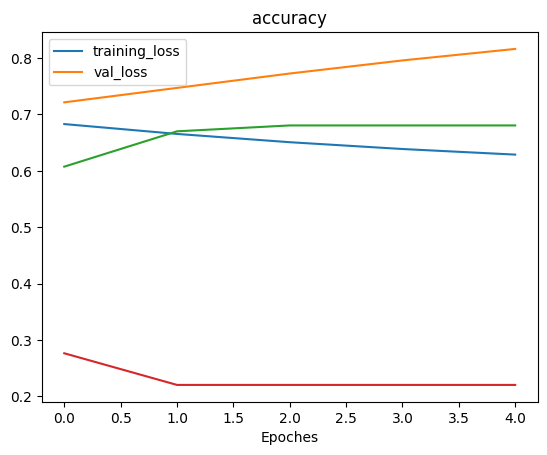

In [91]:
# plot_loss_curves(history1)

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define input shape
input_shape = (224, 224, 3)


# Define input tensor
inputs = Input(shape=input_shape)

# Create ResNet50 model using functional API
resnet_model = ResNet50(
    include_top=False,  # Remove the original classification head
    weights='imagenet', 
    input_tensor=inputs, 
    pooling='avg', 
)
resnet_model.trainable = False #First model which is base line model must be non trainable
# Add a new classification head
x = Dense(256, activation='relu')(resnet_model.output) 
outputs = Dense(2, activation='softmax')(x) 

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

In [20]:
# # # history1 = model1.fit(train_data_10,steps_per_epoch=int(0.50 *len(train_data_10)),epochs=5,validation_data=test_data,validation_steps=int(0.25 * len(test_data)))
# # Baseline model on 50 % training data and 25%testing data

history = model.fit(train_data_10,steps_per_epoch=len(train_data_10),epochs=5,validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
60/60 [==============================] - 10s 104ms/step - loss: 0.6755 - accuracy: 0.6367 - val_loss: 0.9371 - val_accuracy: 0.2184
Epoch 2/5
60/60 [==============================] - 6s 84ms/step - loss: 0.6466 - accuracy: 0.6660 - val_loss: 1.2070 - val_accuracy: 0.2204
Epoch 3/5
60/60 [==============================] - 5s 81ms/step - loss: 0.6307 - accuracy: 0.6722 - val_loss: 0.9240 - val_accuracy: 0.2204
Epoch 4/5
60/60 [==============================] - 6s 85ms/step - loss: 0.6353 - accuracy: 0.6722 - val_loss: 0.9527 - val_accuracy: 0.2204
Epoch 5/5
60/60 [==============================] - 6s 83ms/step - loss: 0.6291 - accuracy: 0.6639 - val_loss: 0.8272 - val_accuracy: 0.2605


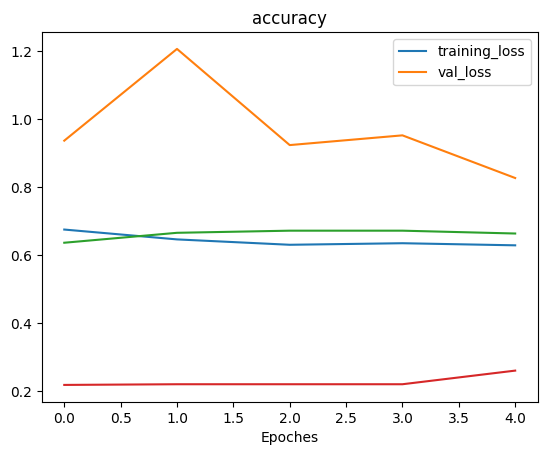

In [21]:
plot_loss_curves(history)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            